In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Mounted at /content/drive


In [3]:
TRAIN_DIR = "/content/drive/My Drive/Capstone_Dataset_Batik/Train"
TEST_DIR = "/content/drive/My Drive/Capstone_Dataset_Batik/Test"

data_dir = pathlib.Path(TRAIN_DIR)

### Set Parameters

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-4

### Data Preparation and Augmentation


In [5]:
def prepare_data():
    print("Memulai persiapan data...")

    # Konfigurasi augmentasi n preprocessing
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=0,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )


    # Load dataset untuk training
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    # Load dataset untuk validasi
    validation_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )

    # Load test data generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    print("\nInformasi Dataset:")
    print(f"Jumlah kelas: {len(train_generator.class_indices)}")
    print("Nama kelas:", train_generator.class_indices)
    print(f"Jumlah batch training: {len(train_generator)}")
    print(f"Jumlah batch validasi: {len(validation_generator)} \n")

    return train_generator, validation_generator, test_generator

In [6]:
# Define the CNN model architecture
def build_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    base_model.trainable = False

    # Build model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Prepare data
train_generator, validation_generator, test_generator = prepare_data()

# Call the function to build the model
model = build_model(train_generator.num_classes)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Memulai persiapan data...
Found 1493 images belonging to 7 classes.
Found 369 images belonging to 7 classes.
Found 140 images belonging to 7 classes.

Informasi Dataset:
Jumlah kelas: 7
Nama kelas: {'insang': 0, 'kawung': 1, 'mega mendung': 2, 'parang': 3, 'sidoluhur': 4, 'truntum': 5, 'tumpal': 6}
Jumlah batch training: 47
Jumlah batch validasi: 12 

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,028,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,287,175 (39.24 MB)

 Trainable params: 8,029,191 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# # Callbacks untuk early stopping, model checkpoint, dan reduce learning rate
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
#     ModelCheckpoint('mobilenetv2_best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
# ]

In [8]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    # callbacks=callbacks,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 931s 18s/step - accuracy: 0.4761 - loss: 1.8769 - val_accuracy: 0.8125 - val_loss: 0.6127
Epoch 2/50
 1/46 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.7812 - loss: 0.6029

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.7812 - loss: 0.6029 - val_accuracy: 0.7647 - val_loss: 1.0019
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.7504 - loss: 0.7758 - val_accuracy: 0.8210 - val_loss: 0.5277
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7812 - loss: 0.6238 - val_accuracy: 0.8235 - val_loss: 0.9794
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8188 - loss: 0.5923 - val_accuracy: 0.8381 - val_loss: 0.5381
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 413ms/step - accuracy: 0.8438 - loss: 0.4112 - val_accuracy: 0.7647 - val_loss: 0.4624
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.8288 - loss: 0.4495 - val_accuracy: 0.8523 - val_loss: 0.5477
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6875 - loss: 1.1901 - val_accuracy: 0.8824 - val_loss: 0.3632
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8536 - loss: 0.4415 - val_accuracy: 0.8693 - val_loss:

In [9]:
# Save the model
model.save("classification_batik_model.h5")
print("Model saved as classification_batik_model.h5")

Model saved as classification_batik_model.h5


In [10]:
# Evaluate the model
from sklearn.metrics import classification_report

test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 11s/step
Classification Report:
              precision    recall  f1-score   support

      insang       1.00      0.95      0.97        20
      kawung       0.70      0.80      0.74        20
mega mendung       0.76      0.95      0.84        20
      parang       0.90      0.90      0.90        20
   sidoluhur       0.62      0.90      0.73        20
     truntum       1.00      0.15      0.26        20
      tumpal       0.90      0.95      0.93        20

    accuracy                           0.80       140
   macro avg       0.84      0.80      0.77       140
weighted avg       0.84      0.80      0.77       140



Text(0.5, 1.0, 'Training and Validation Accuracy')

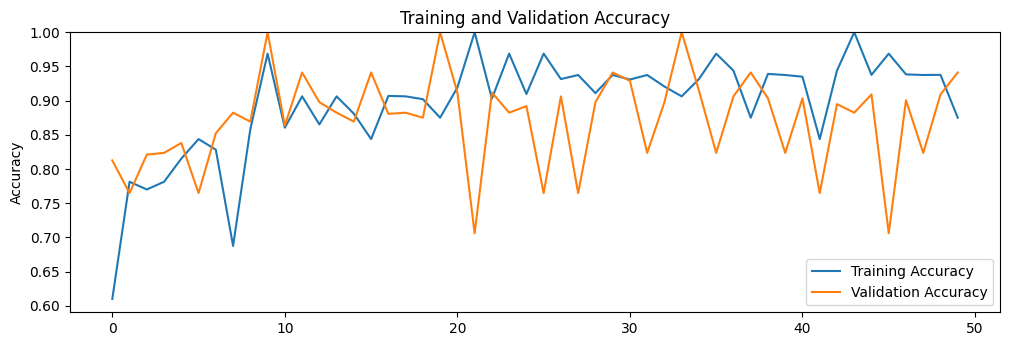

In [11]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

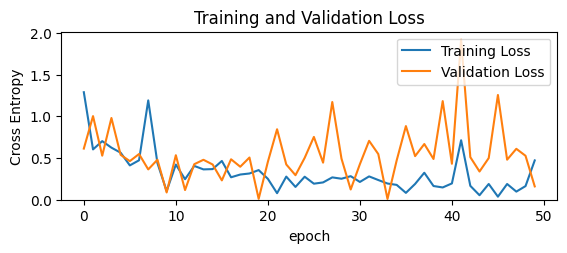

In [12]:
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
# Load kembali model terbaik untuk prediksi
# Prediksi contoh gambar
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

# Lokasi folder testing
TEST_DIR = '/content/drive/My Drive/Capstone_Dataset_Batik/Test'

# Memuat model terbaik
best_model = load_model('classification_batik_model.h5')

# Mendapatkan daftar kelas dari nama subfolder dalam test_dir
classes = [subdir for subdir in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, subdir))]

# Melakukan pengujian untuk setiap kelas
for class_name in classes:
    class_dir = os.path.join(TEST_DIR, class_name)
    image_files = [file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Mengambil satu gambar secara acak dari setiap kelas
    if len(image_files) > 0:
        random_image = random.choice(image_files)
        image_path = os.path.join(class_dir, random_image)

        # Memuat dan memproses gambar
        img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Memprediksi kelas gambar
        prediction = best_model.predict(img_array)
        predicted_class_index = np.argmax(prediction)
        predicted_class = classes[predicted_class_index]

        # Menampilkan hasil prediksi
        print(f"Image: {random_image}")
        print(f"True Class: {class_name}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {np.max(prediction):.2%}")
        print("---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image: insang.2.jpg
True Class: insang
Predicted Class: insang
Confidence: 100.00%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Image: test.kawung.20.jpg
True Class: kawung
Predicted Class: kawung
Confidence: 70.20%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Image: megamendung.16.jpg
True Class: mega mendung
Predicted Class: mega mendung
Confidence: 99.99%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Image: test.parang.7.jpg
True Class: parang
Predicted Class: parang
Confidence: 99.97%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Image: sidoluhur.3.jpg
True Class: sidoluhur
Predicted Class: sidoluhur
Confidence: 87.33%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Image: truntum.10.jpg
True Class: truntum
Predicted Class: sidoluhur
Confidence: 67.34%
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Image: test.tumpal.11.jpg
True Class: tumpal
Predicted Class: tumpal
Confidence: 99.99%
---
